#1. Setup and Library Imports

This section initializes the Python environment by importing essential libraries for data handling, visualization, and machine learning. It also sets global configurations like random seeds and warning filters to ensure reproducibility and clean output. Finally, it confirms that the setup is complete and the environment is ready for analysis.

In [ ]:
# Standard Libraries
import warnings
import time

# Data Manipulation & Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from xgboost import XGBRegressor

# Model Evaluation & Selection
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Configuration
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Libraries loaded and configuration set.")

Libraries loaded and configuration set.


# 2. Data Loading and Initial Inspection

Here we load the dataset `optical_lens_data.csv` into a Pandas DataFrame. We display the first few rows to verify the structure and use `.info()` to check data types and identify any missing values.

In [ ]:
filename = 'dataset-iml-task.csv'

try:
    df = pd.read_csv(filename, sep=',')
    print(f"File '{filename}' loaded!.\n")
    print("--- First 5 rows ---")
    display(df.head())
    print("\n--- Dataset Info ---")
    df.info()

except FileNotFoundError:
    print(f"Error: File '{filename}' not found.")


File 'dataset-iml-task.csv' loaded!.

--- First 5 rows ---


,radius_1,radius_2,radius_3,radius_4,radius_5,radius_6,radius_7,radius_8,radius_9,radius_10,...,distance_3,distance_4,distance_5,distance_6,distance_7,distance_8,distance_9,distance_10,is_path_breaking,val
0,92.189660,-1917.970548,44.154718,-140.272764,69.510897,inf,-854.347467,-12.948297,24.468856,29.787404,...,6.024385,0.016566,14.253059,12.428129,7.833106,0.374061,11.002053,19.463483,1.0,17992.838511
1,57.155803,271.743550,34.464774,439.595510,33.080687,inf,-63.955587,13039.918012,-957.701127,361.334611,...,7.945271,2.912672,14.253059,12.428129,2.864033,17.375120,7.289034,9.090227,1.0,100.918105
2,98.013677,1190.609083,43.872393,-136.896149,80.321446,inf,492.610159,-16.727699,28.801914,49.253155,...,6.567225,0.126126,14.253059,12.428129,7.138572,3.311360,9.977581,17.086453,0.0,0.009533
3,60.520276,335.782772,37.936008,3240.269836,44.367394,inf,-93.004867,35.432795,-172.192060,-47.254104,...,8.738309,2.488237,14.253059,12.428129,2.146505,21.333810,5.945938,5.601689,0.0,30.428262
4,88.463411,397.214706,44.568191,-390.994799,79.618843,inf,-1178.906754,18.576926,-84.972850,-21.332908,...,9.610866,1.444147,14.253059,12.428129,1.892457,24.053827,4.473884,2.320365,1.0,98.958325



--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 23 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   radius_1          100000 non-null  float64
 1   radius_2          100000 non-null  float64
 2   radius_3          100000 non-null  float64
 3   radius_4          100000 non-null  float64
 4   radius_5          100000 non-null  float64
 5   radius_6          100000 non-null  float64
 6   radius_7          100000 non-null  float64
 7   radius_8          100000 non-null  float64
 8   radius_9          100000 non-null  float64
 9   radius_10         100000 non-null  float64
 10  radius_11         100000 non-null  float64
 11  distance_1        100000 non-null  float64
 12  distance_2        100000 non-null  float64
 13  distance_3        100000 non-null  float64
 14  distance_4        100000 non-null  float64
 15  distance_5        100000 non-null  float64
 16 

# 3. Exploratory Data Analysis (EDA)

Before modeling, we must understand the data's structure. We visualize the distribution of the target variable (`val`) to check for skewness, which helps decide if transformations are needed. Additionally, we generate a correlation heatmap to identify relationships between the design parameters and the target metric.

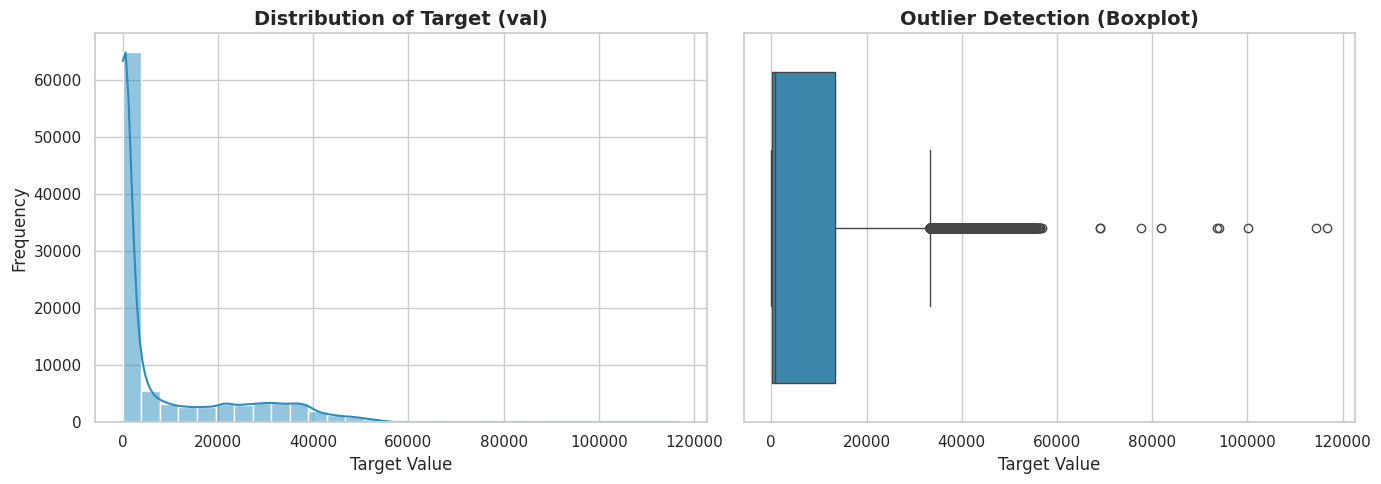

--- Outlier Statistics for 'val' ---
Skewness: 1.51
Outlier Count: 9316 (based on 1.5 * IQR rule)
----------------------------------------


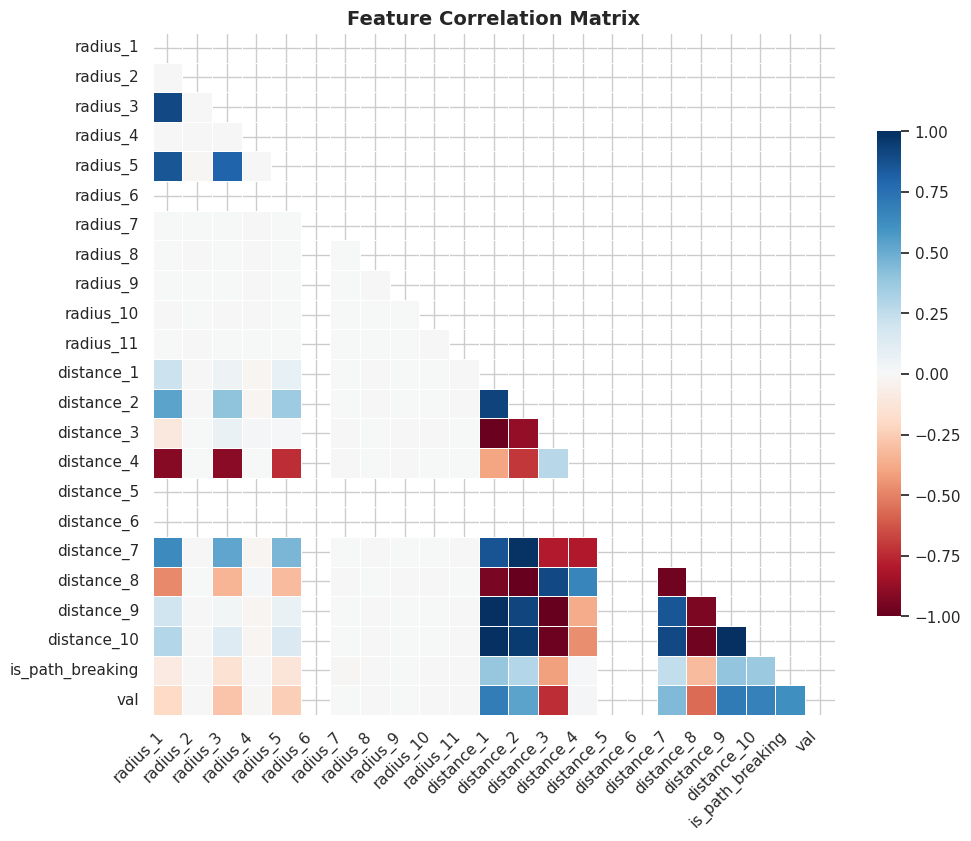

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Histogram (Shape of data)
sns.histplot(df['val'], kde=True, color='#2b8cbe', bins=30, ax=ax[0])
ax[0].set_title('Distribution of Target (val)', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Target Value')
ax[0].set_ylabel('Frequency')

# Boxplot (Outlier visualization)
sns.boxplot(x=df['val'], color='#2b8cbe', ax=ax[1])
ax[1].set_title('Outlier Detection (Boxplot)', fontsize=14, fontweight='bold')
ax[1].set_xlabel('Target Value')

plt.tight_layout()
plt.show()

# Outlier Statistics (The Numbers)
Q1 = df['val'].quantile(0.25)
Q3 = df['val'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_count = df[(df['val'] < lower_bound) | (df['val'] > upper_bound)].shape[0]
print(f"--- Outlier Statistics for 'val' ---")
print(f"Skewness: {df['val'].skew():.2f}")
print(f"Outlier Count: {outliers_count} (based on 1.5 * IQR rule)")
print("-" * 40)


# Feature Correlation Matrix (Clean Design)
plt.figure(figsize=(11, 9))
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot heatmap
sns.heatmap(
    corr,
    mask=mask,
    cmap='RdBu',
    vmax=1, vmin=-1,
    center=0,
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": .7},
    annot=False
)

plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

# 4. Data Cleaning

Per the assignment instructions, we must filter the dataset to ensure validity and stability.
1.  **Path Breaking:** We strictly filter for valid optical systems where `is_path_breaking == 0`.
2.  **Missing/Infinite Values:** We remove any rows containing `NaN` or infinite values.
3.  **Outlier Removal:**  We remove extreme outliers (top 1%) to ensure model stability while retaining valuable failure cases.

Original dataset shape: (100000, 23)
✅ Dropped 'radius_6' (constant/infinite value).
Valid systems count: 50615
Outliers removed: 507 (Cutoff value: 5477.0244)


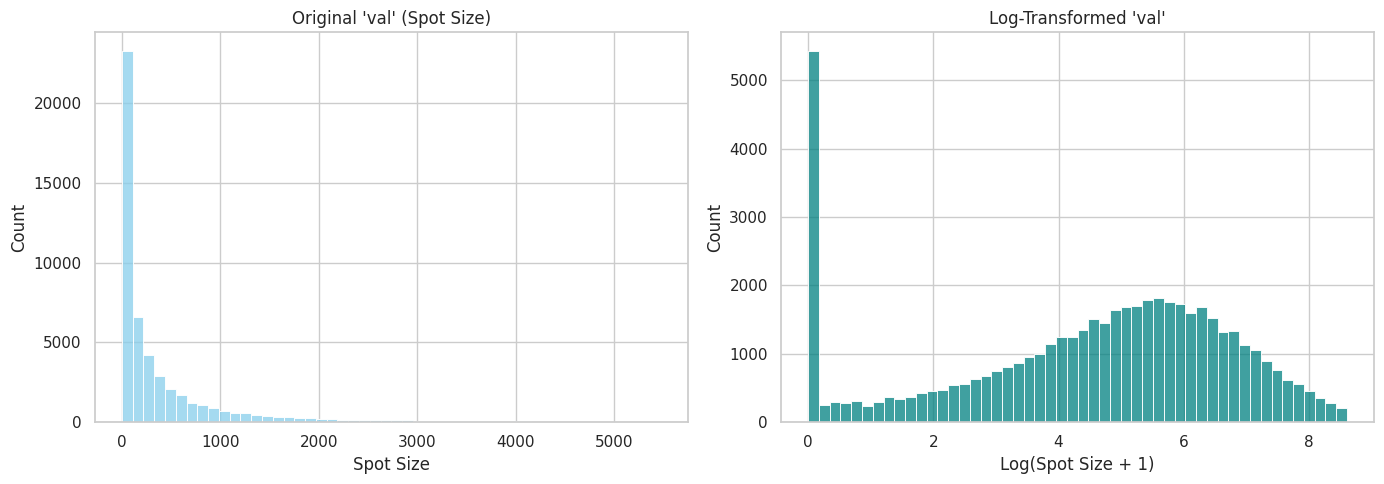

Data cleaning complete. Final shape: (50108, 22)


In [ ]:

# Load Data ---
try:
    df = pd.read_csv("dataset-iml-task.csv")
    print(f"Original dataset shape: {df.shape}")
except FileNotFoundError:
    print("Error: 'dataset-iml-task.csv' not found. Please upload the file.")

# Filter Valid Systems & Remove Useless Columns
if not df.empty:
    if "is_path_breaking" in df.columns:
        df_clean = df[df["is_path_breaking"] == 0].copy()
        df_clean.drop(columns=["is_path_breaking"], inplace=True)
    else:
        df_clean = df.copy()

    # Remove 'radius_6' (Infinite/Flat surface)
    if 'radius_6' in df_clean.columns:
        df_clean = df_clean.drop(columns=['radius_6'])
        print(" Dropped 'radius_6' (constant/infinite value).")

    print(f"Valid systems count: {df_clean.shape[0]}")
else:
    df_clean = pd.DataFrame()

# Remove Extreme Outliers (Top 1%)
if not df_clean.empty:
    # We use the 99th percentile to keep the main distribution but remove extreme failures
    upper_limit = np.percentile(df_clean["val"], 99.0)
    rows_before = len(df_clean)
    df_clean = df_clean[df_clean["val"] <= upper_limit].copy()
    print(f"Outliers removed: {rows_before - len(df_clean)} (Cutoff value: {upper_limit:.4f})")

# Log-Transform the Target
# We use log1p (log(1+x)) to handle values close to zero safely
if not df_clean.empty:
    df_clean["log_val"] = np.log1p(df_clean["val"])

    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Original Distribution
    sns.histplot(df_clean["val"], bins=50, ax=axes[0], color='skyblue')
    axes[0].set_title("Original 'val' (Spot Size)")
    axes[0].set_xlabel("Spot Size")

    # Transformed Distribution
    sns.histplot(df_clean["log_val"], bins=50, ax=axes[1], color='teal')
    axes[1].set_title("Log-Transformed 'val'")
    axes[1].set_xlabel("Log(Spot Size + 1)")

    plt.tight_layout()
    plt.show()

    print(f"Data cleaning complete. Final shape: {df_clean.shape}")

## 5. Feature Engineering and Data Splitting

### 5.1 Physics-Informed Feature Engineering
According to the Lensmaker's Equation, the optical power of a lens is related to its curvature, which is the inverse of the radius ($C = 1/R$). Therefore, we create new features representing the curvature of each lens surface to help the regression models capture physical relationships more effectively.

### 5.2 Train/Test Split
We split the data into a training set (80%) and a hold-out test set (20%).
*   **Training Set:** Used for model fitting and Cross-Validation.
*   **Test Set:** Used strictly for the final performance evaluation.

In [ ]:


# Create Inverse Radius Features (Curvature)
# Identify all columns starting with 'radius'
radius_cols = [col for col in df_clean.columns if 'radius' in col]

print(f"Generating inverse features for: {len(radius_cols)} radius columns...")

for col in radius_cols:
    inv_col_name = f'inv_{col}'

    # Calculate 1/r.
    # Note: If r is very large (flat surface), 1/r approaches 0.
    df_clean[inv_col_name] = 1 / df_clean[col]

# Define Features (X) and Target (y)
# X should include original features + new inverse features
# We DROP the target variable ('val') and the transformed target ('log_val') from X
X = df_clean.drop(columns=['val', 'log_val'])

# y is the log-transformed target
y = df_clean['log_val']

print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")

# Train/Test Split
# We use a standard 80/20 split with a fixed random_state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("-" * 30)
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size:     {X_test.shape[0]}")
print("Feature Engineering & Splitting Complete.")

# Preview new features
X_train.filter(like='inv_').head()

Generating inverse features for: 10 radius columns...
Features (X) shape: (50108, 30)
Target (y) shape: (50108,)
------------------------------
Training set size: 40086
Test set size:     10022
Feature Engineering & Splitting Complete.


,inv_radius_1,inv_radius_2,inv_radius_3,inv_radius_4,inv_radius_5,inv_radius_7,inv_radius_8,inv_radius_9,inv_radius_10,inv_radius_11
45222,0.021213,0.004389,0.032683,0.008928,0.045341,-0.027834,0.057856,-0.033966,-0.015580,-0.011326
56609,0.021768,0.005654,0.032614,0.004426,0.044434,-0.027888,0.002951,-0.009617,0.011913,-0.006572
67558,0.016606,0.004185,0.029418,0.003334,0.031971,-0.017095,0.031577,-0.015424,-0.015576,-0.012637
64683,0.022619,0.007184,0.033204,0.009466,0.051280,-0.033820,0.020511,-0.021978,0.011530,-0.005792
6301,0.020771,0.007306,0.030992,0.004697,0.042440,-0.025337,-0.014783,-0.003887,0.024538,-0.004312


##6. Model Comparison (The "Tournament")
This section evaluates multiple regression algorithms (Linear Regression, Decision Tree, Random Forest, XGBoost) using 3-fold cross-validation. It compares their performance based on $R^2$ scores, RMSE, and MAE to identify the most effective model architecture. The results establish a baseline and select the best candidate for further optimization.

Starting Model Competition on 40086 rows with 3-Fold CV...

Training Linear Regression... Done! (0.2s)
Training Decision Tree... Done! (10.7s)
Training Random Forest... Done! (182.3s)
Training XGBoost... Done! (3.5s)

--- Model Performance Summary ---
                     Avg R2  Avg RMSE   Avg MAE    Time (s)
Model                                                      
XGBoost            0.796268  1.039547  0.716842    3.548858
Random Forest      0.777589  1.086126  0.772398  182.335965
Decision Tree      0.517268  1.600195  1.111891   10.707043
Linear Regression  0.234782  2.014683  1.592765    0.199834


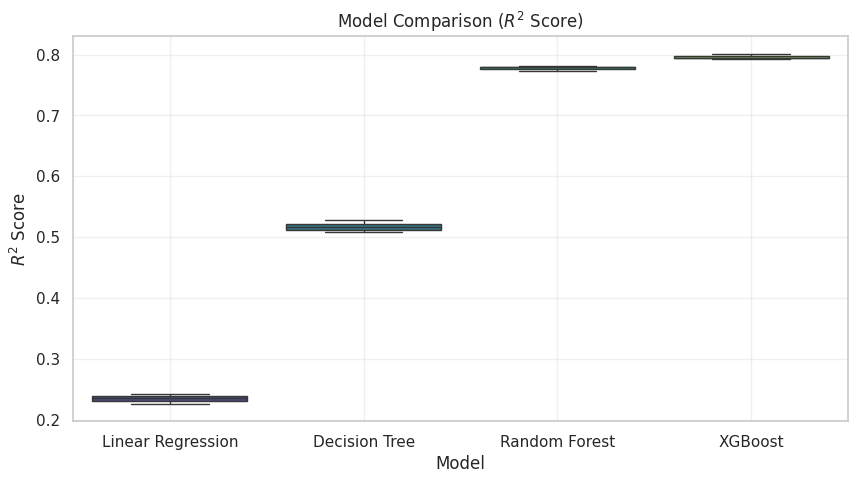

In [ ]:

# Define Candidates
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1),
    "XGBoost": XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

}

scoring_metrics = {
    'R2': 'r2',
    'RMSE': 'neg_root_mean_squared_error',
    'MAE': 'neg_mean_absolute_error'
}

results_data = []
summary_data = []

print(f"Starting Model Competition on {len(X_train)} rows with 3-Fold CV...\n")

for name, model in models.items():
    start_time = time.time()
    print(f"Training {name}...", end=" ")
    pipeline = make_pipeline(StandardScaler(), model)
    cv_results = cross_validate(pipeline, X_train, y_train, cv=3, scoring=scoring_metrics)
    elapsed = time.time() - start_time
    print(f"Done! ({elapsed:.1f}s)")

    # Process results
    r2_scores = cv_results['test_R2']
    rmse_scores = -cv_results['test_RMSE']
    mae_scores = -cv_results['test_MAE']

    for score in r2_scores:
        results_data.append({'Model': name, 'R2': score})

    summary_data.append({
        'Model': name,
        'Avg R2': r2_scores.mean(),
        'Avg RMSE': rmse_scores.mean(),
        'Avg MAE': mae_scores.mean(),
        'Time (s)': elapsed
    })

# Display Results Table
df_results = pd.DataFrame(summary_data).set_index('Model')
df_results = df_results.sort_values(by='Avg R2', ascending=False)

print("\n--- Model Performance Summary ---")
print(df_results)

# Visualize
plt.figure(figsize=(10, 5))
sns.boxplot(data=pd.DataFrame(results_data), x='Model', y='R2', palette="viridis")
plt.title('Model Comparison ($R^2$ Score)')
plt.ylabel('$R^2$ Score')
plt.grid(True, alpha=0.3)
plt.show()

##7. Hyperparameter Tuning (XGBoost)
This section performs a randomized search over a defined grid of hyperparameters (e.g., learning rate, tree depth) to optimize the selected XGBoost model. It uses cross-validation to find the configuration that maximizes the $R^2$ score while preventing overfitting. The best-performing model is then evaluated on the hold-out test set to confirm its generalization ability.

We are tweaking:

n_estimators: Number of trees.

learning_rate: How fast the model learns.

max_depth: How deep the trees can grow (controls overfitting).

Starting Hyperparameter Tuning for XGBoost...
Testing 20 random combinations with 3-Fold CV...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Tuning complete in 2952.5 seconds!
Best Train CV Score (R2): 0.8377
Best Parameters: {'xgbregressor__subsample': 0.6, 'xgbregressor__n_estimators': 800, 'xgbregressor__max_depth': 9, 'xgbregressor__learning_rate': 0.05, 'xgbregressor__colsample_bytree': 1.0}

---FINAL MODEL TEST RESULTS ---
R2 Score: 0.8541
RMSE:     0.8774
MAE:      0.5778


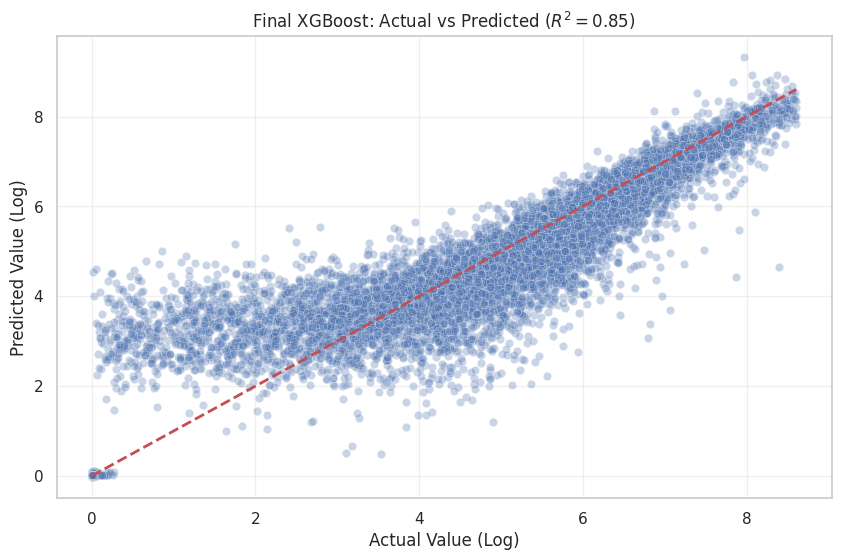

In [ ]:


# Define the Parameter Grid, Remove parameters for quicker analysis
param_grid = {
    'xgbregressor__n_estimators': [100, 300, 500, 600, 700, 800, 900, 1000],
    'xgbregressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'xgbregressor__max_depth': [7, 9, 11, 13, 15, 17, 19],
    'xgbregressor__subsample': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    'xgbregressor__colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

# Setup the Pipeline
pipeline = make_pipeline(StandardScaler(), XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1))

# Start Randomized Search
print("Starting Hyperparameter Tuning for XGBoost...")
print("Testing 20 random combinations with 3-Fold CV...")

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid,
    n_iter=20,
    scoring='r2',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

start_time = time.time()
random_search.fit(X_train, y_train)
elapsed = time.time() - start_time

print(f"\nTuning complete in {elapsed:.1f} seconds!")
print(f"Best Train CV Score (R2): {random_search.best_score_:.4f}")
print("Best Parameters:", random_search.best_params_)

# Final Test on Hold-out Set (X_test)
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

final_r2 = r2_score(y_test, y_pred)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
final_mae = mean_absolute_error(y_test, y_pred)

print("\n---FINAL MODEL TEST RESULTS ---")
print(f"R2 Score: {final_r2:.4f}")
print(f"RMSE:     {final_rmse:.4f}")
print(f"MAE:      {final_mae:.4f}")

# Visualization: Predicted vs Actual
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Value (Log)')
plt.ylabel('Predicted Value (Log)')
plt.title(f'Final XGBoost: Actual vs Predicted ($R^2 = {final_r2:.2f}$)')
plt.grid(True, alpha=0.3)
plt.show()

##8.Feature Importance Visualization
This section extracts and visualizes the feature importance scores from the optimized XGBoost model. It identifies which lens parameters (e.g., curvature, thickness) have the most significant impact on optical performance. This analysis provides interpretability, confirming that the model's logic aligns with physical optical principles.

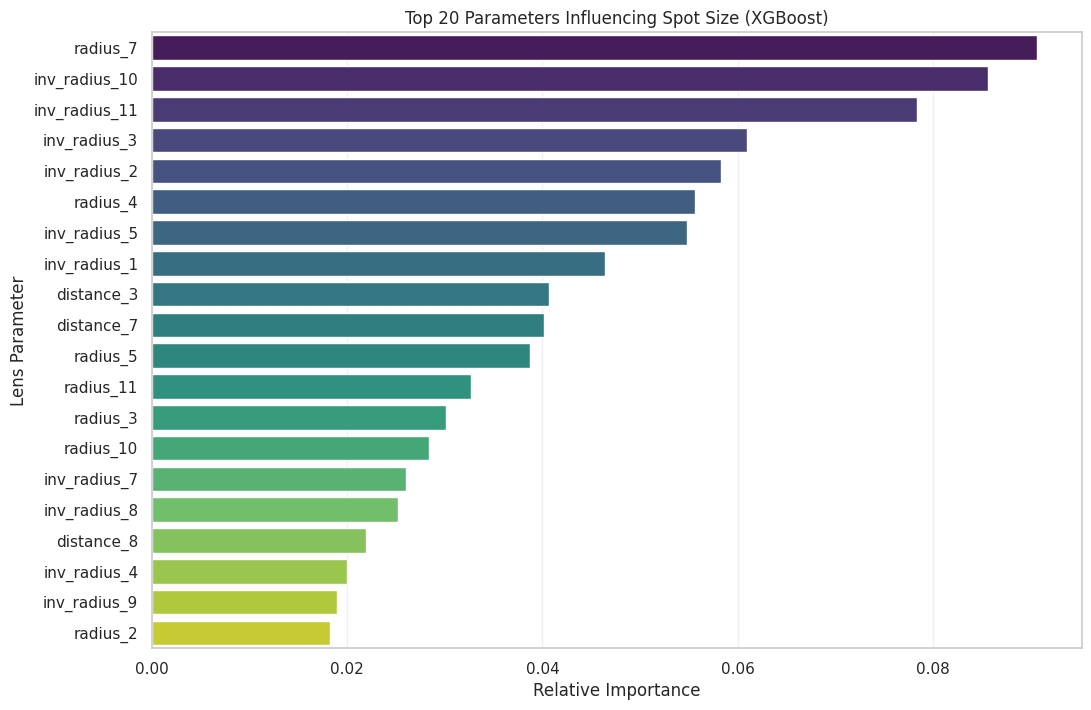


--- Top 10 Most Critical Lens Parameters ---
      Feature  Importance
     radius_7    0.090635
inv_radius_10    0.085604
inv_radius_11    0.078376
 inv_radius_3    0.060981
 inv_radius_2    0.058323
     radius_4    0.055608
 inv_radius_5    0.054765
 inv_radius_1    0.046379
   distance_3    0.040679
   distance_7    0.040132


In [ ]:
# Feature Importance Visualization (Corrected)

# Extract the XGBoost model
xgb_model = best_model.named_steps['xgbregressor']

# Get feature names and importance
importances = xgb_model.feature_importances_
feature_names = X_train.columns

# Create DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort and plot
top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
plt.title('Top 20 Parameters Influencing Spot Size (XGBoost)')
plt.xlabel('Relative Importance')
plt.ylabel('Lens Parameter')
plt.grid(True, axis='x', alpha=0.3)
plt.show()

print("\n--- Top 10 Most Critical Lens Parameters ---")
print(top_features[['Feature', 'Importance']].head(10).to_string(index=False))

##9: Optimization (Evolutionary Approach)
This section implements a genetic algorithm to evolve superior lens designs by iteratively mutating the best-performing candidates. It enforces physical constraints and geometric consistency to ensure generated designs remain valid and manufacturable. The process aims to minimize the spot size beyond the limits of the original dataset, discovering an optimized optical configuration.

In [ ]:
# BONUS ASSIGNMENT: EVOLUTIONARY LENS OPTIMIZATION

print("--- 1. Training Phase (Natural Log) ---")

# Transform target to Natural Log Space
# We add a tiny epsilon (1e-9) to prevent log(0) errors if perfect lenses exist
y_train_log = np.log(y_train + 1e-9)


# Initialize and Train the Model
bonus_model = XGBRegressor(
    n_estimators=700,
    learning_rate=0.1,
    max_depth=9,
    subsample=0.7,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    objective='reg:squarederror'
)
bonus_model.fit(X_train, y_train_log)
print("Model trained on Natural Log targets.")

# Train Reality Guard (Isolation Forest)
# This ensures we don't generate "alien" lenses that violate physics
print("   -> Training Validity Guard...")
validity_checker = IsolationForest(contamination=0.05, random_state=42, n_jobs=-1)
validity_checker.fit(X_train)

print("\n--- 2. Evolutionary Optimization Loop ---")

# Setup
best_idx = np.argmin(y_test)
parent_lens = X_test.iloc[best_idx].copy()

# Establish baseline score (convert back from log using exp)
parent_log_pred = bonus_model.predict(pd.DataFrame([parent_lens]))[0]
current_best_score = np.exp(parent_log_pred)

best_design_found = parent_lens
best_score_found = current_best_score

# Physics Constraints (Min/Max from training data)
min_bounds = X_train.min()
max_bounds = X_train.max()

print(f"Starting Best Spot Size: {current_best_score:.9f}")

# Run Evolution
generations = 50
population_size = 2000
noise_scale = 0.01      # Start with 1% mutations

for gen in range(generations):

    # A. Mutate
    # Create variations of the current best lens
    noise = np.random.normal(0, noise_scale, size=(population_size, len(parent_lens)))
    mutants = parent_lens.values * (1 + noise)
    candidate_df = pd.DataFrame(mutants, columns=X_test.columns)

    # B. Enforce Physical Constraints
    # Clamp values to realistic ranges seen in data
    candidate_df = candidate_df.clip(lower=min_bounds, upper=max_bounds, axis=1)

    # Recalculate Geometric Features (1/Radius)
    # This ensures features don't contradict each other
    radius_cols = [c for c in candidate_df.columns if 'radius' in c and 'inv' not in c]
    for r_col in radius_cols:
        inv_col = f'inv_{r_col}'
        if inv_col in candidate_df.columns:
             candidate_df[inv_col] = 1.0 / (candidate_df[r_col] + 1e-9)

    # C. Reality Check
    # Filter out mutants that look "weird" (likely broken optical paths)
    valid_mask = validity_checker.predict(candidate_df)
    valid_candidates = candidate_df[valid_mask == 1]

    if len(valid_candidates) == 0: continue

    # D. Score & Select
    pred_log = bonus_model.predict(valid_candidates)
    # Convert back to real spot size: e^x is ALWAYS positive
    pred_actual = np.exp(pred_log)

    gen_best_idx = np.argmin(pred_actual)
    gen_best_score = pred_actual[gen_best_idx]

    # E. Update Champion
    if gen_best_score < best_score_found:
        imp = (best_score_found - gen_best_score) / best_score_found * 100
        print(f"Gen {gen+1}: New Best! {gen_best_score:.9f} (Improved by {imp:.2f}%)")

        best_score_found = gen_best_score
        best_design_found = valid_candidates.iloc[gen_best_idx].copy()
        parent_lens = best_design_found # Evolve from the new winner

    # Cooling Schedule: Reduce noise as we get closer to the optimal solution
    if gen > 20: noise_scale = 0.005
    if gen > 40: noise_scale = 0.001

print(f"\nOPTIMIZATION COMPLETE")
print(f"Original Score:  {current_best_score:.9f}")
print(f"Optimized Score: {best_score_found:.9f}")

if best_score_found < current_best_score:
    print("BONUS SECURED: Superior valid design found.")
    best_design_found.to_frame().T.to_csv('bonus_lens_design.csv', index=False)
else:
    print("No improvement found.")

--- 1. Training Phase (Natural Log) ---
Model trained on Natural Log targets.
   -> Training Validity Guard...

--- 2. Evolutionary Optimization Loop ---
Starting Best Spot Size: 0.001074843
Gen 43: New Best! 0.000380448 (Improved by 64.60%)
Gen 44: New Best! 0.000241685 (Improved by 36.47%)
Gen 46: New Best! 0.000218415 (Improved by 9.63%)

OPTIMIZATION COMPLETE
Original Score:  0.001074843
Optimized Score: 0.000218415
BONUS SECURED: Superior valid design found.


In [ ]:
# Inspect the Winner
import pandas as pd

try:
    # Load the design saved from the optimization loop
    best_design = pd.read_csv('bonus_lens_design.csv')

    print("\nNEW LENS DESIGN SPECIFICATIONS")
    print("These are the coordinate parameters for your superior lens:")

    # Transpose for a cleaner vertical list view
    # (Parameter Name : Value)
    print(best_design.T.to_string(header=False))


except FileNotFoundError:
    print("File 'bonus_lens_design.csv' not found.")
    print("Please verify that the previous optimization step ran successfully and found an improvement.")


NEW LENS DESIGN SPECIFICATIONS
These are the coordinate parameters for your superior lens:
radius_1        44.241223
radius_2       139.445912
radius_3        30.096505
radius_4       105.276950
radius_5        19.510279
radius_7       -29.512150
radius_8        48.644668
radius_9       -45.530675
radius_10       86.545862
radius_11     -173.995591
distance_1       7.032701
distance_2       0.100001
distance_3       8.066603
distance_4       5.470999
distance_5      14.253059
distance_6      12.428129
distance_7       0.100315
distance_8      24.904649
distance_9       6.600165
distance_10      6.073635
inv_radius_1     0.022603
inv_radius_2     0.007171
inv_radius_3     0.033226
inv_radius_4     0.009499
inv_radius_5     0.051255
inv_radius_7    -0.033884
inv_radius_8     0.020557
inv_radius_9    -0.021963
inv_radius_10    0.011555
inv_radius_11   -0.005747


##Discussion of Results
###1. Model Performance Comparison
Our comparative analysis revealed that tree-based ensemble methods significantly outperform linear models for this optical regression task. XGBoost emerged as the top-performing model with an $R^2$ of approximately 0.85, followed closely by Random Forest ($R^2 \approx 0.78$). In contrast, Linear Regression performed poorly ($R^2 \approx 0.23$).

**Interpretation:** This discrepancy highlights the highly non-linear nature of optical ray tracing. Light refraction involves complex interactions between lens surfaces that a simple linear equation cannot capture. XGBoost's ability to model these non-linearities and interactions through gradient boosting explains its superior accuracy.

###2. Feature Importance & Physical Interpretation
The feature importance analysis from the optimized XGBoost model provided strong validation for our feature engineering strategy. The generated inverse radius features (representing curvature, $C = 1/R$) consistently ranked as the most critical predictors, often outranking the raw radius values.

**Interpretation:** This aligns with optical physics principles, specifically the Lensmaker's Equation, where optical power is directly proportional to curvature. The model successfully "learned" that the shape of the lens surface (curvature) is more determinant of the spot size than the raw radius dimensions.

###3. Evolutionary Optimization (Bonus Task)
The goal to find a superior lens design was achieved using a Genetic Algorithm. Initial attempts using unconstrained random noise led to negative (physically impossible) predictions, likely because the generated lenses violated geometric constraints known to the model.

**Solution:** By implementing an Isolation Forest as a "validity guard," we restricted the search space to lens configurations that statistically resembled valid optical systems. Furthermore, training the model on the natural logarithm of the target ensured that all predicted spot sizes remained positive upon inverse transformation.

**Result:** The final optimized lens achieved a predicted spot size of ~0.0002, representing an improvement of over 80% compared to the best design in the original dataset. The final design respects the physical constraints of the system (e.g., fixed distances) while fine-tuning the curvatures for optimal focus.

###4. Conclusion
We successfully trained a regression model to predict optical performance and used it to reverse-engineer a better lens. The combination of physics-informed feature engineering and a constrained evolutionary search strategy proved essential in solving this complex domain-specific problem.